# Spam Classification
## Table of Contents
### 0. Setup
### 1. Exploratory Data Analysis
- 1.1 Basic Information
- 1.2 Features
### 2. Data Preprocessing
- 2.1 Feature Engineering
- 2.2 Tokenization
- 2.3 Word Vectorization
### 3. Model Development and Training
- Linear Separability
- Model Hyperparameter Tuning
- Model Camparison
### 4. Model Evaluation
- Confusion Matrix
- Top Feature Examination
### 5. Final Prediction

## 0. Setup

In [88]:
# basics
import re
import pandas as pd
import numpy as np
import os
import argparse
import string
import nltk

# visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import find
from sklearn.preprocessing import StandardScaler

# models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ignore convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [89]:
# load data
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

## 1. Exploratory Data Analysis

### 1.1 Basic Information

### 1.2 Date

### 1.3 Video and User Information

### 1.4 Comment

## 2. Data Preprocessing

### 2.1 Feature Engineering

In [82]:
# date column into binary
train_df['DATE'] = train_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)

### 2.2 Comment Preprocessing

In [83]:
# basic functions
def clean_text1(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def clean_text2(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def count_vect(text):
    return ' '.join(text)

def clean_text(text):
    text = clean_text1(text)
    text = clean_text2(text)
    text = tokenize(text)
    return count_vect(text)

In [84]:
train_df['cleaned_text'] = train_df['CONTENT'].apply(clean_text)

### 2.3 Word Vectorization: CountVectorizer

In [85]:
count_vectorizer = CountVectorizer()
x_1 = count_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x_count_vect = np.hstack((x_1, x_2))
y = train_df['CLASS']

### 2.4 Word Vectorization: TF-IDF Vectorizer

In [86]:
tf_vectorizer = TfidfVectorizer()
x_1 = tf_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x_tf_idf = np.hstack((x_1, x_2))
y = train_df['CLASS']

## 3. Model Development and Training

### 3.1 Linear Separability: Principal Component Analysis

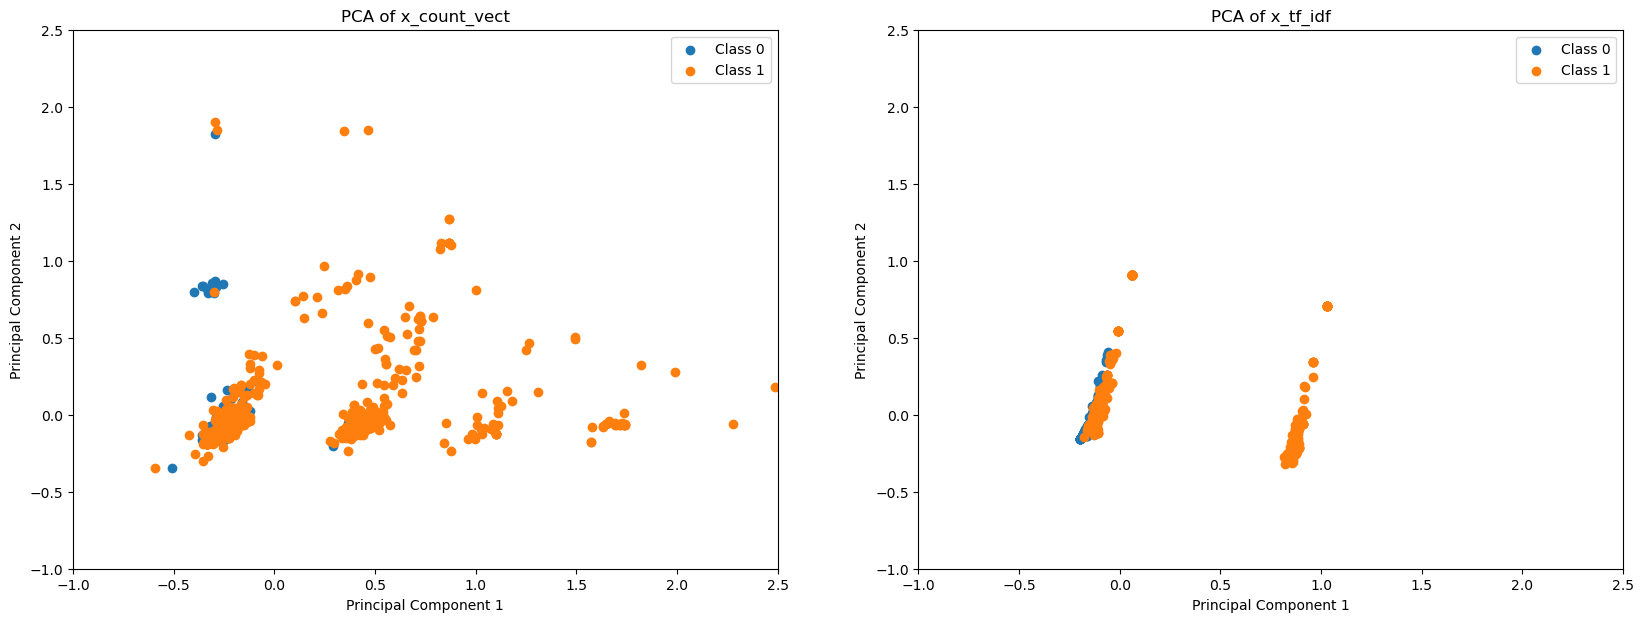

In [87]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# count vectorizer
pca_count_vect = PCA(n_components=2)
x_pca_count_vect = pca_count_vect.fit_transform(x_count_vect)


# Plot for count vectorizer
axes[0].set_title('PCA of x_count_vect')
for class_value in np.unique(y):
    axes[0].scatter(x_pca_count_vect[y == class_value, 0], x_pca_count_vect[y == class_value, 1], label=f'Class {class_value}')
axes[0].set_xlim(-1, 2.5)
axes[0].set_ylim(-1, 2.5)
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()

# tf_idf
pca_tf_idf = PCA(n_components=2)
x_pca_tf_idf = pca_tf_idf.fit_transform(x_tf_idf)

# Plot for tf_idf
axes[1].set_title('PCA of x_tf_idf')
for class_value in np.unique(y):
    axes[1].scatter(x_pca_tf_idf[y == class_value, 0], x_pca_tf_idf[y == class_value, 1], label=f'Class {class_value}')
axes[1].set_xlim(-1, 2.5)
axes[1].set_ylim(-1, 2.5)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()

plt.show()

### 3.2 Linear Separability: Hard Margin Support Vector Machine

#### Count Vectorizer

In [12]:
x_c_train, x_c_test, y_c_train, y_c_test = train_test_split(x_count_vect, y, test_size=0.2)

In [13]:
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_c_train, y_c_train)
y_c_pred = hard_margin_svm.predict(x_c_test)

count_vector_hard_margin_svm_accuracy_score = accuracy_score(y_c_test, y_c_pred)
count_vector_hard_margin_svm_accuracy_score

0.9343065693430657

#### TF-IDF

In [14]:
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(x_tf_idf, y, test_size=0.2)

In [15]:
# tf_idf
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_t_train, y_t_train)
y_pred = hard_margin_svm.predict(x_t_test)

tf_idf_hard_margin_svm_accuracy_score = accuracy_score(y_t_test, y_pred)
tf_idf_hard_margin_svm_accuracy_score


0.9197080291970803

### 3.3 Model Hyperparameter Tuning

#### Count Vectorizer

In [16]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 10000]
}

c_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
c_grid_search.fit(x_c_train, y_c_train)
c_grid_search.best_params_

KeyboardInterrupt: 

In [17]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 10000]
}

t_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
t_grid_search.fit(x_t_train, y_t_train)
t_grid_search.best_params_

{'C': 100, 'max_iter': 100, 'solver': 'saga'}

### 3.4 Model Comparison

#### Count Vectorizer

In [18]:
# compare the best models with other models
lr_c_model = c_grid_search.best_estimator_

lda_c = LinearDiscriminantAnalysis()
qda_c = QuadraticDiscriminantAnalysis()
gnb_c = GaussianNB()
svc_c = SVC()
rf_c = RandomForestClassifier()
gbc_c = GradientBoostingClassifier()


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# lda_cv_scores = cross_val_score(lda_c, x_c_train, y_c_train, cv=5)
# qda_cv_scores = cross_val_score(qda_c, x_c_train, y_c_train, cv=5)
# gnb_cv_scores = cross_val_score(gnb_c, x_c_train, y_c_train, cv=5)
svc_cv_scores = cross_val_score(svc_c, x_c_train, y_c_train, cv=5)
rf_cv_scores = cross_val_score(rf_c, x_c_train, y_c_train, cv=5)
gbc_cv_scores = cross_val_score(gbc_c, x_c_train, y_c_train, cv=5)
print('LDA:', lda_cv_scores.mean())
print('QDA:', qda_cv_scores.mean())
print('GNB:', gnb_cv_scores.mean())
print('SVC:', svc_cv_scores.mean())
print('RF:', rf_cv_scores.mean())
print('GBC:', gbc_cv_scores.mean())
print('LR:', c_grid_search.best_score_)


NameError: name 'lda_c' is not defined

#### TF-IDF

In [20]:
lr_t_model = t_grid_search.best_estimator_

lda_t = LinearDiscriminantAnalysis()
qda_t = QuadraticDiscriminantAnalysis()
gnb_t = GaussianNB()
svc_t = SVC()
rf_t = RandomForestClassifier()
gbc_t = GradientBoostingClassifier()

In [21]:
lda_tv_scores = cross_val_score(lda_t, x_t_train, y_t_train, cv=5)
qda_tv_scores = cross_val_score(qda_t, x_t_train, y_t_train, cv=5)
gnb_tv_scores = cross_val_score(gnb_t, x_t_train, y_t_train, cv=5)
svc_tv_scores = cross_val_score(svc_t, x_t_train, y_t_train, cv=5)
rf_tv_scores = cross_val_score(rf_t, x_t_train, y_t_train, cv=5)
gbc_tv_scores = cross_val_score(gbc_t, x_t_train, y_t_train, cv=5)
print('LDA:', lda_tv_scores.mean())
print('QDA:', qda_tv_scores.mean())
print('GNB:', gnb_tv_scores.mean())
print('SVC:', svc_tv_scores.mean())
print('RF:', rf_tv_scores.mean())
print('GBC:', gbc_tv_scores.mean())
print('LR:', t_grid_search.best_score_)

/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LDA: 0.7954337899543378
QDA: 0.6328767123287671
GNB: 0.7461187214611872
SVC: 0.9077625570776254
RF: 0.9315068493150684
GBC: 0.904109589041096
LR: 0.9232876712328766


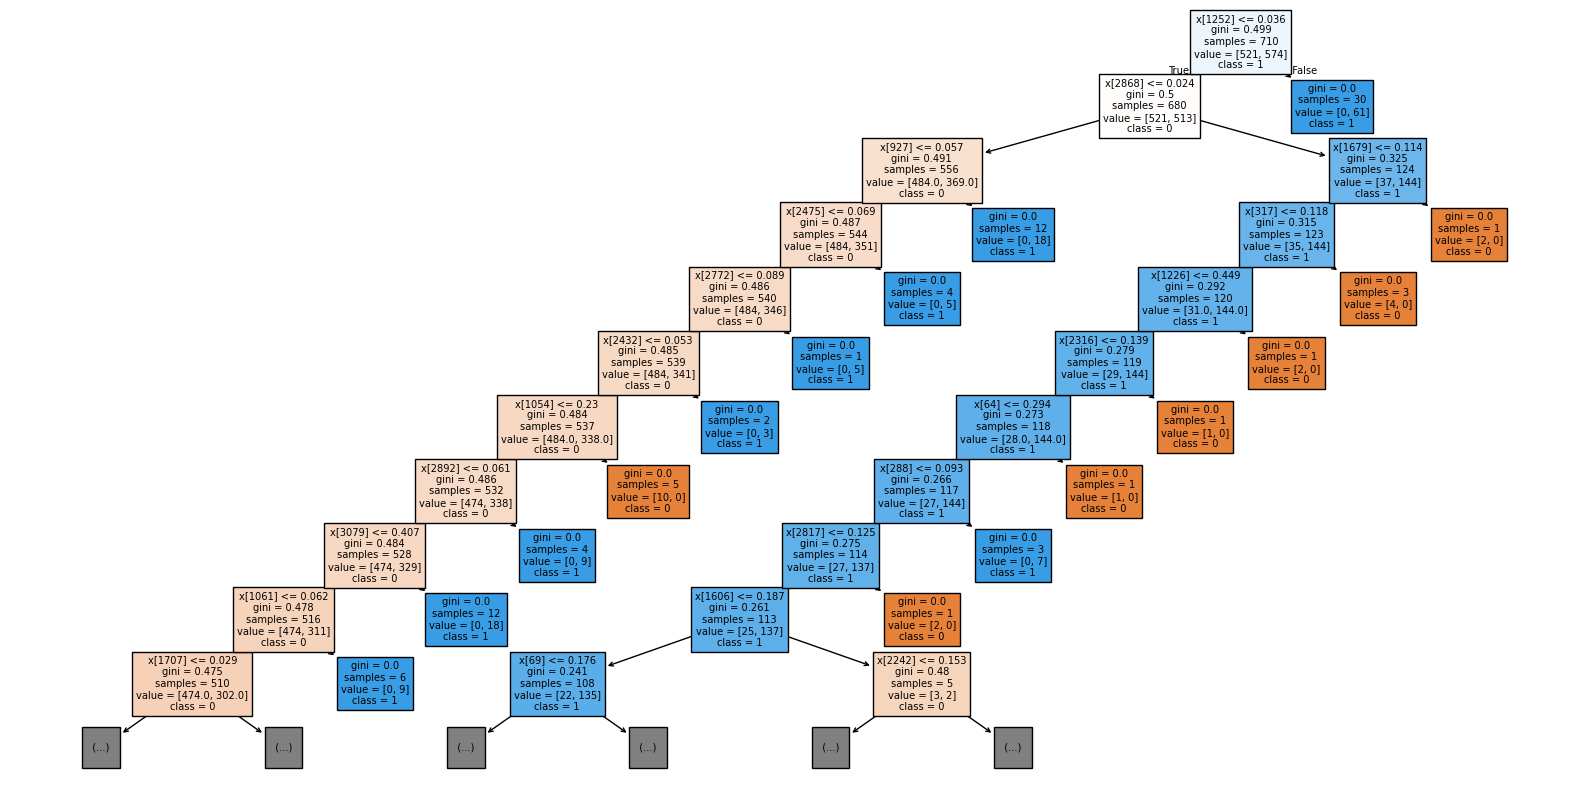

In [ ]:
from sklearn.tree import plot_tree, DecisionTreeClassifier

rf_t.fit(x_t_train, y_t_train)

decision_tree = rf_t.estimators_[5]

plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(decision_tree, max_depth=10, filled=True, class_names = ['0', '1'])

plt.show()

In [76]:
feature_names = tf_vectorizer.get_feature_names_out()
importances = rf_t.feature_importances_

list(feature_names).index('www')
list(feature_names).index('check')
list(feature_names)[2868]


'video'

In [78]:
tree_structure = decision_tree.tree_
feature_indices = tree_structure.feature

impurity_change = (tree_structure.impurity - tree_structure.impurity[tree_structure.children_left]) * tree_structure.weighted_n_node_samples

# Get the indices of the top 5 nodes with the largest impurity change
top_5_nodes = np.argsort(impurity_change)[-5:]

# Print information about the top 5 nodes
print("Top 5 nodes with the biggest split:")
for node in reversed(top_5_nodes):  # Reverse to display in descending order
    left_child = tree_structure.children_left[node]
    right_child = tree_structure.children_right[node]
    print(f"Node {node}: Feature index {tree_structure.feature[node]}, impurity change = {impurity_change[node]:.4f}, samples = {tree_structure.n_node_samples[node]}")


Top 5 nodes with the biggest split:
Node 18: Feature index 2592, impurity change = 29.2929, samples = 478
Node 68: Feature index 518, impurity change = 24.0918, samples = 227
Node 35: Feature index 3127, impurity change = 22.2147, samples = 361
Node 1: Feature index 2868, impurity change = 9.3660, samples = 680
Node 522: Feature index 2868, impurity change = 7.0747, samples = 41


## 4. Model Evaluation

## 5. Final Prediction 

## CountVector

In [40]:
test_df['cleaned_text'] = test_df['CONTENT'].apply(clean_text)
count_vectorizer = CountVectorizer()
count_vectorizer.fit(list(train_df['cleaned_text']))
count_vectorizer.fit(list(test_df['cleaned_text']))

x_1 = count_vectorizer.transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x = np.hstack((x_1, x_2))
y = train_df['CLASS']

In [41]:
rf = RandomForestClassifier()
rf.fit(x, y)

RandomForestClassifier()

In [42]:
test_df['DATE'] = test_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)

In [ ]:
x_1_test = count_vectorizer.transform(list(test_df['cleaned_text'])).toarray()
x_2_test = np.array(test_df['DATE']).reshape(-1, 1)
x_test = np.hstack((x_1_test, x_2_test))

In [44]:
y_pred = rf.predict(x_test)

In [46]:
sol = pd.read_csv("./sample_submission.csv")
sol['CLASS'] = y_pred
sol.head()
sol.to_csv("count_vector_rf.csv", index=False)